# Fit Bimodal Distributions
The goal in these notebooks to fit a distribution to the observed count data.
As illustrated in [the previous notebook](./0_visualize-void-distribution.ipynb), we find that there are generally two populations of voids - small and large - and we're going to fit a bimodal distribution to predict the expected number of counts of voids of different sizes.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multiprocessing import Pool
from functools import partial
from scipy import stats, optimize
from tqdm import tqdm
import pandas as pd
import numpy as np

## Load in the Data
Get the void counts from all frames

In [2]:
data = pd.read_pickle('../datasets/initial_data.pkl')
print(f'Loaded in {len(data)} frames')

Loaded in 8115 frames


## Establish the Fitting Approach
The number of voids counted in a particular view of a microscope is a random process - the actual count depends the overall density of voids and the particular region we chose to look at. 
Consequently, we will express the probability of observing the number of voids as a certain size as [a Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution).
The Poisson distribution describes the number of counts of a particular event given a "rate" parameter, &lambda;.
Our task is to predict how this "rate" parameter varies over cells of different sizes.

We will assume the rate parameter varies smoothly as a function of void size and that function has two peaks.
Given the "bimodal" distribution of void sizes we found previously, we'll assume a functional form that is the sum of two Gaussians.

$\lambda(r) = \lambda_1 exp(-(r - r_1)^2 / \sigma_1^2) + \lambda_2 exp(-(r - r_2)^2 / \sigma_2^2)$

This functional form has 6 fitting parameters: a base rate ($\lambda_i$), and the mean ($r_i$) and width ($\sigma_i$) of how that parameter varies over time for two different population of voids ($i \in \{1, 2\}$)

We will fit this distribution by binning our data according to void size then adjusting these parameters to minimizing the difference between the expected and actual number of values in that bin.

Our first step is to get an example frame

In [3]:
example_frame = data.iloc[50]

In [4]:
bins = np.linspace(0, 35, 32)

Text(0, 0.5, 'Count')

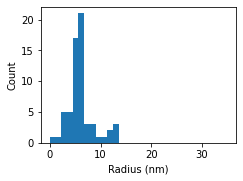

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.hist(example_frame['void_radii'], bins=bins)

ax.set_xlabel('Radius (nm)')
ax.set_ylabel('Count')

You can see the that there is a roughly bimodal distribution to the data.

In [6]:
def compute_count_distribution(r, rate_small, rate_large, mean_small, mean_large, width_small, width_large):
    """Generate the distribution of expected counts for voids of a certain size.
    
    The "density/rate" parameter describing the distribution of counts is defined by
    
    :math:`\lambda(r) = \lambda_1 exp(-(r - r_1)^2 / \sigma_1) + \lambda_2 exp(-(r - r_2)^2 / \sigma_2)`
    
    where :math:`\lambda` is the rate parameter of a Poisson distribution
    
    Args:
        r: Radius of the void
        rate_small: Rate parameter for small voids (:math:`\lambda_1`)
        rate_large: Rate parameter for large voids (:math:`\lambda_2`)
        mean_small: Mean size of the small voids (units: nm)
        mean_large: Mean size of the large voids (units: nm)
        width_small: Variance in size of small voids (units: nm)
        width_large: Variance in size of large voids (units: nm)
    Returns:
        Probability distribution of expected void counts
    """
    
    rate_all = rate_small * np.exp(-(r - mean_small) ** 2 / width_small ** 2) + \
        rate_large * np.exp(-(r - mean_large) ** 2 / width_large ** 2)
    
    # TODO (wardlt): I'm just computing the value based on the center of the bin
    #  an average (computed using an integral) for the bin range woud be more precise
    return stats.poisson(rate_all)

In [7]:
r_center = bins[:-1] + np.diff(bins) / 2   # Get the center of each bin
count_distrib = compute_count_distribution(r_center, 5, 2, 5, 15, 4, 4)

Text(0, 0.5, 'Expected Count')

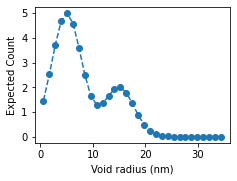

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(r_center, count_distrib.mean(), '--o')

ax.set_xlabel('Void radius (nm)') 
ax.set_ylabel('Expected Count')

This gives us a smoothly-varying number of expected counts and the bi-modal character that we expect

Fit the distribution's parameters to observed data

In [9]:
def objective_fun(radii, bins, *params) -> float:
    """Compute the "log loss" of a distribution given a set of observed counts and distribution parameters
    
    Args:
        radii: Radii of voids observed in image
        bins: Bin edges on which to divide categories of voids
        params Parameters of the void size distribution
    Returns:
        - "Log loss" of distribution (higher values indicate worse fit)
    """
    
    # Compute the counts per bin
    counts, edges = np.histogram(radii, bins)
    
    # Get the center of each bin
    center = bins[:-1] + np.diff(edges) / 2
    
    # Compute the count distributions for each bin
    count_dist = compute_count_distribution(center, *params)
    
    # Compute the log probability of the observed data given the distributions
    return -count_dist.logpmf(counts).sum()

In [10]:
def fit_distribution(radii, bins):
    """Fit the probability distribution given observed radii and bins for void sizes
    
    Args:
        radii: Radii of voids observed in image
        bins: Bin edges on which to divide categories of voids
    Returns:
        Fit values for the distribution
    """
    
    # Make the function to be minimized
    #  Set the radii and bin values of the objective function defined above
    fun = lambda x: objective_fun(radii, bins, *x)
    
    # Define the bounds for the values
    bounds = [
        (0, None),  # Rates are positive
        (0, np.inf),
        (0, 10),  # Small voids are between 0 and 10nm
        (12, None),  # Large voids are larger than 12nm
        (1, 10),  # Width is between 1 and 10nm
        (1, 10)
    ]
        
    
    # Run optimization
    return optimize.minimize(lambda x: objective_fun(radii, bins, *x), 
                             x0=(5, 2, 5, 15, 4, 4),
                             method='Powell',
                             bounds=bounds).x

In [11]:
res = fit_distribution(example_frame['void_radii'], bins)

Text(0, 0.5, 'Count')

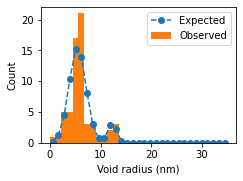

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

count_distrib = compute_count_distribution(r_center, *res)
ax.plot(r_center, count_distrib.mean(), '--o', label='Expected')

ax.hist(example_frame['void_radii'], bins=bins, label='Observed')

ax.legend()
ax.set_xlabel('Void radius (nm)') 
ax.set_ylabel('Count')

The result is that we can get a pretty good model for the void size distributions

## Run the fitting over all frames
Now that we have the function, let's use it on all available data


In [13]:
%%time
with Pool() as pool:
    fit_fun = partial(fit_distribution, bins=bins)
    outputs = [x for x in tqdm(pool.imap(fit_fun, data['void_radii']), total=len(data))]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8115/8115 [02:09<00:00, 62.81it/s]

CPU times: user 29.7 s, sys: 3.89 s, total: 33.6 s
Wall time: 2min 9s


Store the results in a Pandas dataframe

In [14]:
results = pd.DataFrame(outputs, columns=['density_small', 'density_large', 'radii_small', 'radii_large', 'std_small', 'std_large'])

In [15]:
results = pd.concat([data[['source', 'temp', 'frame_id', 'void_radii']], results], axis=1)

Lets plot how it varies for a trajectory

In [16]:
subset = results.query('temp == 575.')

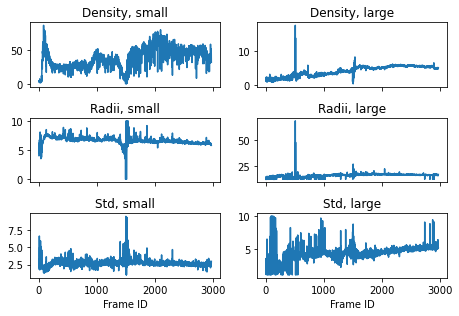

In [17]:
plot_cols = results.columns[-6:]
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(6.5, 4.5))

for col, ax in zip(plot_cols, axs.flatten()):
    ax.plot(subset['frame_id'], subset[col])
    ax.set_title(col.capitalize().replace("_", ", "))
    

for ax in axs[-1, :]:
    ax.set_xlabel('Frame ID')
fig.tight_layout()
fig.savefig('figures/distribution-params-575C.png', dpi=320)

Plot a few example cells

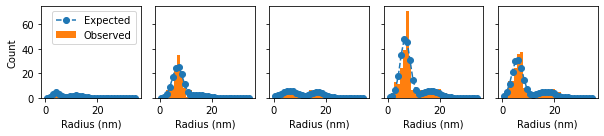

In [18]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(8.5, 2.))

frames = np.linspace(0, len(subset)-1, len(axs), dtype=np.int)

for frame, ax in zip(frames, axs):
    frame = subset.iloc[frame]
    
    count_distrib = compute_count_distribution(r_center, *frame.values[-6:])
    ax.plot(r_center, count_distrib.mean(), '--o', label='Expected')

    ax.hist(frame['void_radii'], bins=bins, label='Observed')
    
    ax.set_xlabel('Radius (nm)')

axs[0].set_ylabel('Count')
axs[0].legend()
fig.tight_layout()
fig.savefig('figures/distributions-575C-over-time.png', dpi=320)

Save the data for later use

In [19]:
results.to_csv('data/fitted-distributions.csv', index=False)